In [27]:
using LinearAlgebra
using ToeplitzMatrices
using StatsBase
using Plots
using Polynomials
using FFTW
pyplot()

include("SFbyCKMS.jl")
include("ARMA_Generator.jl")

dB (generic function with 1 method)

In [28]:
################################################
#
# Title: wiener_filter_scalar.jl
# Author: Jared McBride (11-15-2019)
#
# Here we find the Wiener filter for two scalar
# processes, the signal and the predictors (or
# observations).
# The inputs are
#   sig : the timeseries we are approximating
#   pred : the timeseries with which we will
#       be approximating the signal.
#   M : the degree of the approximating Laurent
#       polynomials used in construction of the
#       spectra.
# The output is
#   h : the sequence of length 2M+1.
#
##############################################

function wiener_filter(pred,sig,M)
    # pred are the predictors
    # sig is the sequence to be approximated
    # M is the degree of the approximating Laurent polynomials

    # Approximate autocorr and crosscor (Laurent degree M)
    R_pred    = autocov(pred,1:M+1)
    R_predsig = crosscov(pred,sig, 1:M+1)

#     Smoothing
    LL = Int(floor(M/2))
    lam1 = 1 .- 6*((0:LL)/M).^2 .+ 6*((0:LL)/M).^3
    lam2 = 2*(1 .- (LL+1:M)/M).^3
    lam = [lam1; lam2]

    R_pred = R_pred.*lam
    R_predsig = R_predsig.*lam

    l = Scalar_CKMS_c(R_pred);

    S_minus_num = Toeplitz([1; l; zeros(M)],[1; zeros(2M)])
    S_plus_num = S_minus_num'
    L = Toeplitz([0; 1; zeros(2M - 1)],zeros(2M+1));
    S_predsig = Toeplitz([R_predsig; zeros(M)],
                [R_predsig[1]; zeros(2M)]);

    MM = S_plus_num*S_predsig
    MM = Toeplitz(LowerTriangular(MM))
    H = S_minus_num\MM
    h = H[:,1];
    # h comes out size 2M+1
end


wiener_filter (generic function with 1 method)

Test new variantion of ARMA_gen:

Test 

In [29]:
steps = 10^4;
M = Int(floor(2*sqrt(steps)))
M = 40;
w = [1, -5/3, 4, -20/3];

### True Process:

In [30]:
l = [1, -5/4, 3/8]

3-element Array{Float64,1}:
  1.0  
 -1.25 
  0.375

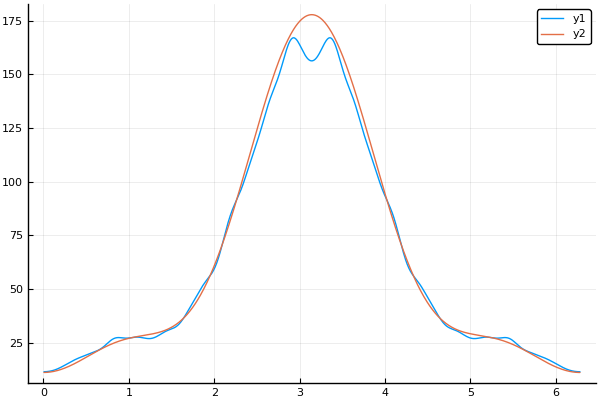

In [31]:
X = ARMA_gen([],w, steps = steps, e = []);

z_spect_num = z_spect(X,M,win = "Par")

tranfer_Fun(z) = Poly(w)(z)
z_spect_ana(z) = abs(tranfer_Fun(z))^2

Nex = 1000
Theta = 2*pi/Nex*(1:Nex)

S_num = [z_spect_num(exp(im*theta)) for theta in Theta]
S_ana = [z_spect_ana(exp(im*theta)) for theta in Theta]
plot(Theta,[(real.(S_num)) (S_ana)])

### Filtered Process

In [42]:
pred = e = randn(steps);
sig = X
M = 30

# pred are the predictors
# sig is the sequence to be approximated
# M is the degree of the approximating Laurent polynomials

# Approximate autocorr and crosscor (Laurent degree M)
R_pred    = autocov(pred,1:M+1)
R_predsig = crosscov(pred,sig, 1:M+1)

#     Smoothing
LL = Int(floor(M/2))
lam1 = 1 .- 6*((0:LL)/M).^2 .+ 6*((0:LL)/M).^3
lam2 = 2*(1 .- (LL+1:M)/M).^3
lam = [lam1; lam2]

R_pred = R_pred.*lam
R_predsig = R_predsig.*lam

l = Scalar_CKMS_c(R_pred);

S_minus_num = Toeplitz([1; l; zeros(M)],[1; zeros(2M)])
S_plus_num = S_minus_num'
L = Toeplitz([0; 1; zeros(2M - 1)],zeros(2M+1));
S_predsig = Toeplitz([R_predsig; zeros(M)],
            [R_predsig[1]; zeros(2M)]);

MM = S_plus_num*S_predsig
MM = Toeplitz(LowerTriangular(MM))
H = S_minus_num\MM
h = H[:,1];
# h comes out size 2M+1

In [43]:
xx = ARMA_gen([],h, steps = steps);

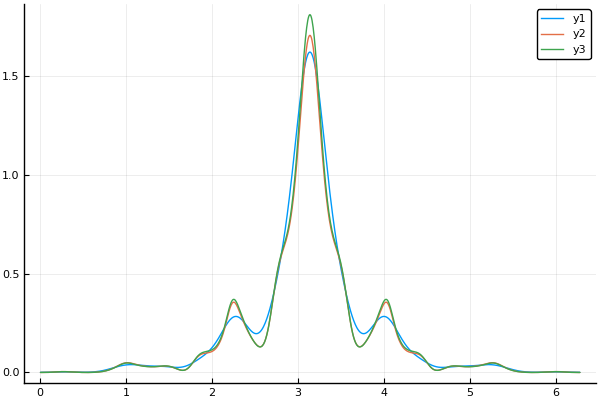

In [44]:
z_spect_wf_num = z_spect(xx,M,win = "Par")
z_spect_wf_error = z_spect(X .- xx,M,win = "Par")
z_spect_predictor = z_spect(e,M,win = "Par")

tranfer_Fun(z) = Poly(h)(z)
z_spect_wf_ana(z) = abs(tranfer_Fun(z))^2

Hz_spect_pred_H(z) = real(tranfer_Fun(z)*z_spect_predictor(z)*conj(tranfer_Fun(z)))

Nex = 1000
Theta = 2*pi/Nex*(1:Nex)

S_wf_num = [z_spect_wf_num(exp(im*theta)) for theta in Theta]
S_wf_HpredH = [Hz_spect_pred_H(exp(im*theta)) for theta in Theta]
S_wf_ana = [z_spect_wf_ana(exp(im*theta)) for theta in Theta]

plot(Theta,[real.(S_wf_num) S_wf_ana S_wf_HpredH])

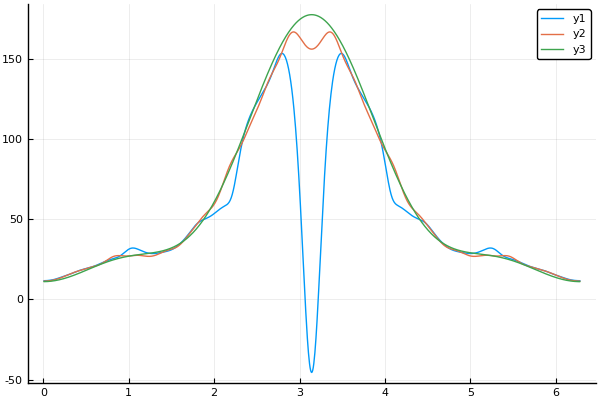

In [45]:
eps = X .- xx;
z_spect_eps = z_spect(eps,M,win = "Par")

mm = 20
N = length(X)
R_xy = zeros(mm+1)
R_xy[1] = 1/N*dot(e,X)
for m = 1:mm
    R_xy[m+1] = 1/(N-m)*dot(e[1:N-m],X[m+1:N])/R_xy[1]
end
R_xy[1] = .5
lam = .5*(1 .+ cos.(pi/mm*(0:mm)))
z_spect_Rxy(z) = sum([lam[i+1]*(R_xy[i+1]'*z^(-i) + R_xy[i+1]*z^(i)) for i = 0 : mm-1])

z_spec_y_wf(z) = z_spect_eps(z) + conj(tranfer_Fun(z))*z_spect_Rxy(z) +
                    tranfer_Fun(z)*conj(z_spect_Rxy(z)) - Hz_spect_pred_H(z)

S_y_wf = [z_spec_y_wf(exp(im*theta)) for theta in Theta]
S_y = [z_spect_num(exp(im*theta)) for theta in Theta]

plot(Theta,[real.(S_y_wf) real.(S_y) S_ana])

Now to test orthogonality of errors with the signal.

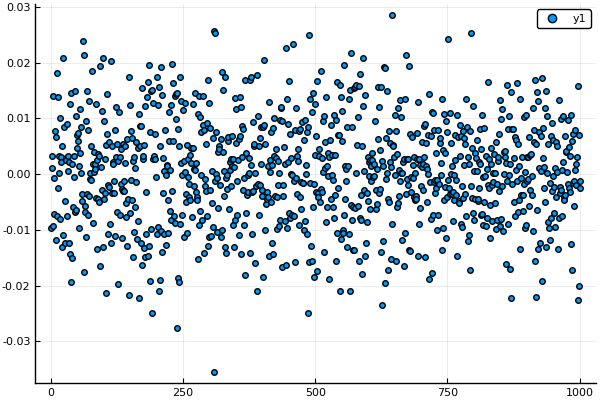

In [36]:
e = randn(steps);
mm = 1000
C = crosscor(e,(X.-xx),0:mm)
scatter(C)

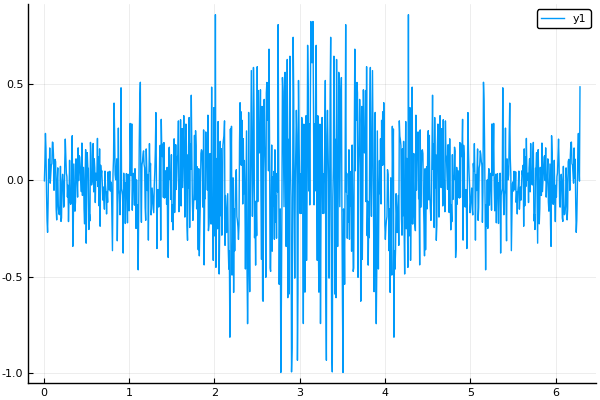

In [37]:
lam = .5*(1 .+ cos.(pi/mm*(0:mm)))
C[1] = .5*C[1]
z_spect_Rxy(z) = sum([lam[i+1]*(C[i+1]'*z^(-i) + C[i+1]*z^(i)) for i = 0 : mm])
Z = map(th -> exp(im*th),Theta)
plot(Theta,real.(z_spect_Rxy.(Z)))

### Filtered with smoothing periodogram

In [38]:
# e = randn(steps);
M_spec = 40
h = wf_approx_spect(e,X,5,M_spec)

xxx = ARMA_gen([],h, steps = steps);

z_spect_wf_num = z_spect(xxx,M,win = "Par")

tranfer_fun = Poly(h)
z_spect_wf_ana(z) = abs(tranfer_fun(z))^2

Nex = 1000
Theta = 2*pi/Nex*(1:Nex)

S_wf_num = [z_spect_wf_num(exp(im*theta)) for theta in Theta]
S_wf_ana = [z_spect_wf_ana(exp(im*theta)) for theta in Theta]
plot(Theta,[real.(S_wf_num) S_wf_ana])

UndefVarError: UndefVarError: wf_approx_spect not defined